The simple dependent click model is based on the following principles:
* the first result is always examined
* a result can only be examined if the previous result was examined
* stop if a clicked result is satisfactory (with probability 1-lambda_r)
* continue if result is not satisfactory

In [101]:
from random import random
from collections import Counter

def sdcmLearnParams(click_log_path):
    """ Learns parameters for simple dependent click model.
    
    Args:
        click_log_path (str): Path to training data.
    
    Returns:
        dict: Learnt click model parameters.
        
    """
    
    with open(click_log_path,'r') as f:
        # global rank click counter
        rank_counter = Counter()
        # counter for clicks on consecutive ranks
        pair_counter = Counter()
        # rank counter that resets for each new session
        temp_counter = Counter()
        result_pages = []
        for line in f:
            line = line.split()
            time_passed = line[1]
            if time_passed == '0':
                result_pages = []
                for rank, _ in temp_counter.items():
                    prev_idx = int(rank)-1
                    if temp_counter[prev_idx] > 0:
                        # increase counter if previous url was clicked
                        pair_counter[prev_idx] += 1
                temp_counter = Counter()
            if line[2] == 'Q':
                result_pages.append(line[5:])
            else:
                url = line[3]
                for results in result_pages:
                    try:
                        rank = results.index(url)
                        rank_counter[rank] += 1
                        temp_counter[rank] += 1
                        break
                    except:
                        pass
    lambdas = {r+1:pair_counter[r]/rank_counter[r] for r in pair_counter.keys()}
    return lambdas

def sdcmAttrProbs(ranking, attr):
    """ Assigns attractiveness probabilities for list of relevance labels.
    
    Args:
        ranking (list): Ranked list of relevance labels.
        atrr (dict): Attractiveness parameters for different relevance labels.
    
    Returns:
        list: List of attractiveness probabilities.
    
    """
    probs = [attr[label] for i, label in enumerate(ranking)]
    return probs
    
def sdcmAssignClicks(probs, params):
    """ Assigns clicks based on attractiveness and satisfactoriness probabilities.
    
    Args:
        probs (list): Attractiveness probabilities for ranking.
        params (dict): Satisfactoriness probabilities per rank.
        
    Returns:
        list: Assigned clicks.
    
    """
    clicks = []  
    for i in range(len(probs)):
        if i == 0:
            # for first result, click probability equals attractiveness
            p_click = probs[i]
        else:
            prev_click = clicks[i-1]
            if prev_click == 1:
                p_satisf = params[i]
                # stochastically decide satisfactoriness    
                outcome = random()
                if outcome < p_satisf:
                    # when the clicked result was satisfactory, stop
                    clicks += ([0] * (len(probs) - len(clicks)))
                    print('Result {} was satisfactory!'.format(i))
                    break
                else:
                    p_click = probs[i]
            else:
                p_click = probs[i]
        # stochastically decide click 
        outcome = random()
        if outcome < p_click:
            clicks.append(1)
        else: clicks.append(0)
    return clicks

def sdcmClickModel(ranking, click_log_path='YandexRelPredChallenge.txt', attr=attr_nav):
    """ Trains click model parameters and assigns clicks to ranked list of relevance labels.
    
    Args:
        ranking (list):  Ranked list of relevance labels.
        click_log_path (str): Path to training data.        
        attr (dict): Attractiveness parameters for different relevance labels.
        
    Returns:
        list: Assigned clicks.
    
    """
    params = sdcmLearnParams(click_log_path)
    probs = sdcmAttrProbs(ranking, attr)
    clicks = sdcmAssignClicks(probs, params)
    return clicks

"""Click model attractiveness parameters"""
attr_perf = {'HR':1.0, 'R':0.5, 'N':0.0}
attr_nav = {'HR':0.95, 'R':0.5, 'N':0.05}
attr_inf = {'HR':0.9, 'R':0.7, 'N':0.4}

In [103]:
ranking = ['HR', 'R', 'R', 'N', 'HR', 'N', 'R']
sdcmClickModel(ranking)

[1, 0, 1, 1, 1, 0, 1]

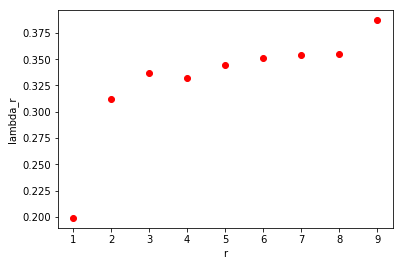

In [5]:
import matplotlib.pyplot as plt

for r, lambda_value in params.items():
    plt.plot(r,lambda_value,'ro')
 
plt.xlabel('r')
plt.ylabel('lambda_r')    
plt.show()    